In [58]:
# Package imports
import random
from random import randint
import time

import os
import json
import string
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as cx
import warnings
import shapely
from shapely.geometry import Point, Polygon, LineString, LinearRing
import math
from tqdm import tqdm

## Testing out random points along vertices

[<LINESTRING (-55382.871 6685481.111, -9795.675 6680161.486)>, <LINESTRING (-9795.675 6680161.486, 38218.444 6691691.532)>, <LINESTRING (-55382.871 6685481.111, 38218.444 6691691.532)>]


<Axes: >

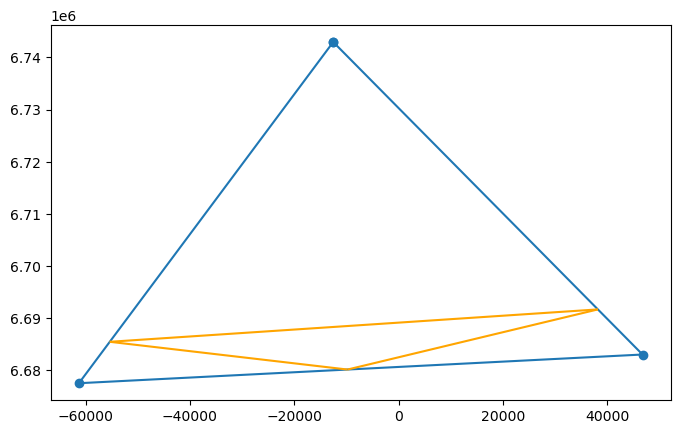

In [59]:
gdf = gpd.read_file('geojson_polygons/triangle.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

gdf_bounds = gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in gdf.boundary[0].coords], columns=['geometry']),geometry='geometry')

gdf_verts = shapely.LineString([shapely.Point(x) for x in gdf.boundary[0].coords][0:2])


def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

gdf_verts = gpd.GeoDataFrame(pd.DataFrame(segments(gdf.boundary[0]), columns=['geometry']), geometry='geometry')

def point_on_line(line):
    p1 = line.coords[0]
    p2 = line.coords[-1]
    u = random.uniform(0,1)
    
    x1 = [(1-u) * x for x in p1]
    x2 = [u*x for x in p2]
    return Point(np.add(x1,x2))

def points_on_vertices(shape):
    vertices = segments(shape.boundary[0])
    return gpd.GeoDataFrame(pd.DataFrame([point_on_line(x) for x in vertices], columns=['geometry']),geometry='geometry')

def inner_polygon(shape):
    vertices = segments(shape.boundary[0])
    points_list = [point_on_line(x) for x in vertices]
    linestring_list = [LineString([points_list[i], points_list[i+1]]) for i in range(len(points_list)-1)] + [LineString([points_list[0], points_list[-1]])]
    return points_list, linestring_list

def inner_polygons(shape, n=1):
    poly_list = []
    for i in range(n):
        _, poly =  inner_polygon(shape)
        poly_list += poly
    print(poly_list)
    return gpd.GeoDataFrame(pd.DataFrame(poly_list, columns=['geometry']), geometry='geometry')

inner_polys = inner_polygons(gdf)

fig, ax = plt.subplots(1,1,figsize=(8,8))

gdf_bounds.plot(ax=ax)
gdf_verts.iloc[:,:].plot(ax=ax)
inner_polys.plot(ax=ax, color='orange')


## Testing out polygon/vertex buffers

            Name                                           geometry
0     NORTH WEST  POLYGON Z ((712628.801 740370.193 0.000, 71262...
1  NORTH CENTRAL  POLYGON Z ((723376.597 738898.086 0.000, 72337...
2     SOUTH EAST  POLYGON Z ((714674.273 732453.119 0.000, 71464...
3  SOUTH CENTRAL  POLYGON Z ((715059.495 734107.257 0.000, 71505...
4        CENTRAL  POLYGON Z ((713734.291 734380.708 0.000, 71373...


<Axes: >

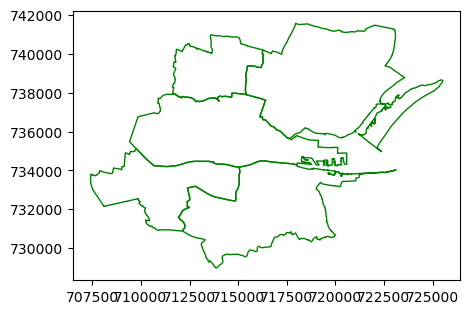

In [60]:
gdf = gpd.read_file('geojson_polygons/dcc.geojson')
convert = False
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

print(gdf)

#gdf_buffer = gdf.buffer(-100000)

fig, ax = plt.subplots(1,1,figsize=(5,5))

#gdf_buffer.plot(ax=ax, facecolor='orange')
gdf.plot(ax=ax, facecolor='none', edgecolor='green', label='name')

## Taking a look at plotting ways from OSM

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


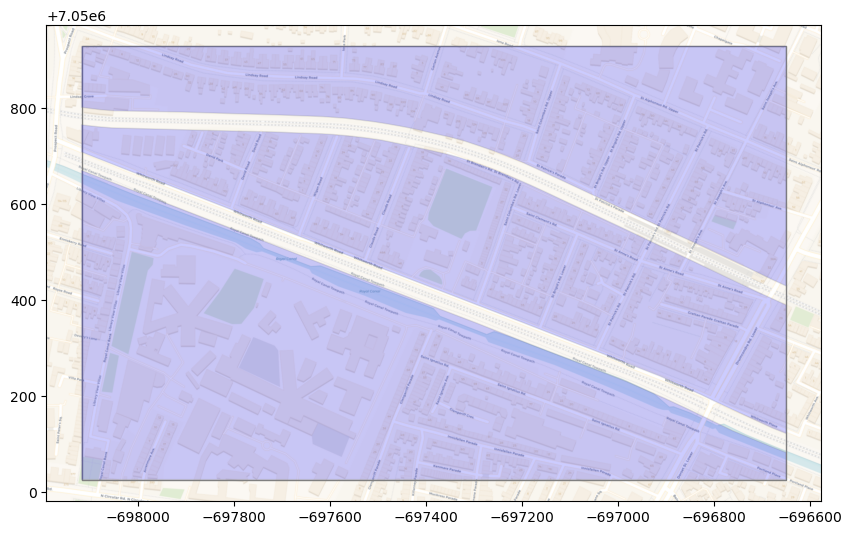

In [61]:
dcc = gpd.read_file('geojson_polygons/whitworth.geojson').to_crs(3857)
rail = gpd.read_file('geojson_polygons/whitworth_rail.geojson').to_crs(3857)

rail = rail[rail['geometry'].geom_type == "LineString"]

rail_buffer = gpd.GeoDataFrame(pd.DataFrame(rail.buffer(15), columns=['geometry']), geometry='geometry')

join_test = dcc.overlay(rail_buffer, how='symmetric_difference')
join_test2 = dcc.overlay(join_test, how='intersection')

fig, ax = plt.subplots(1,1,figsize=(10,10))
#dcc.plot(ax=ax, facecolor='none', edgecolor='green')
#rail_buffer.plot(ax=ax, color='orange')
dcc.plot(ax=ax,facecolor='none', edgecolor='grey')


##join_test.plot(ax=ax, facecolor='pink', edgecolor='grey')
join_test2.plot(ax=ax, facecolor='blue', edgecolor='grey', alpha=0.2)
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


## Trying out tiling shapes over given Polygons

/tmp/ipykernel_53797/2896156331.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  poly_test = tri_between_points(gdf_bb_points.iloc[0,:][0],20)


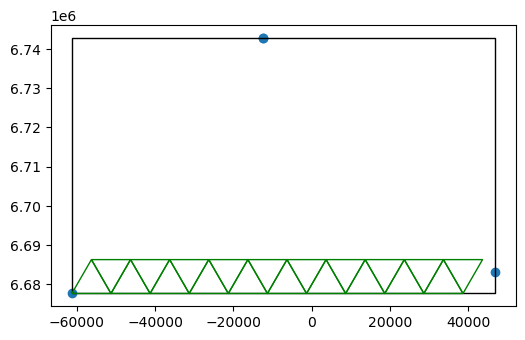

In [62]:
gdf = gpd.read_file('geojson_polygons/triangle.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)


def get_bounds_points(shape):
    return gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in shape.boundary[0].coords], columns=['geometry']),geometry='geometry')

gdf_bounds = get_bounds_points(gdf)

def get_bb(shape):
    bb = shape.total_bounds
    bb_poly = Polygon([(bb[0],bb[1]),(bb[0], bb[-1]),(bb[-2], bb[-1]),(bb[-2], bb[1])])
    return gpd.GeoDataFrame(pd.DataFrame([bb_poly], columns=['geometry']), geometry='geometry')

gdf_bb = get_bb(gdf)
gdf_bb_points = get_bounds_points(gdf_bb)


def eq_tri(point, odd, side=10000):
    ax, ay = point.x, point.y
    if odd:
        b = Point([ax + side, ay])
        c = Point([ax + side/2, ay + np.sqrt(3/4 * (side*side))])
    else:
        b = Point([ax + side, ay])
        c = Point([ax + side/2, ay - np.sqrt(3/4 * (side*side))])
    abc = Polygon([Point(ax,ay),point, b, c])
    return c, abc#gpd.GeoDataFrame(pd.DataFrame([abc], columns=['geometry']), geometry='geometry')

def tri_between_points(point, num):
    tri_list = []
    for i in range(num):
        next_point, tri = eq_tri(point,i%2==0)
        point = next_point
        tri_list.append(tri)
    return gpd.GeoDataFrame(pd.DataFrame(tri_list, columns=['geometry']), geometry='geometry')

poly_test = tri_between_points(gdf_bb_points.iloc[0,:][0],20)

fig, ax = plt.subplots(1,1,figsize=(6,5))

gdf_bounds.plot(ax=ax)
gdf_bb.plot(ax=ax, facecolor='none', edgecolor='black')
poly_test.plot(ax=ax, facecolor='none', edgecolor='green')
plt.show()

input polygon: POLYGON ((-696649.1726421195 7050026.3802579455, -696649.1726421195 7050928.828509125, -698116.6493336892 7050928.828509125, -698116.6493336892 7050026.3802579455, -696649.1726421195 7050026.3802579455))
Buffer size =  66.70348598044471


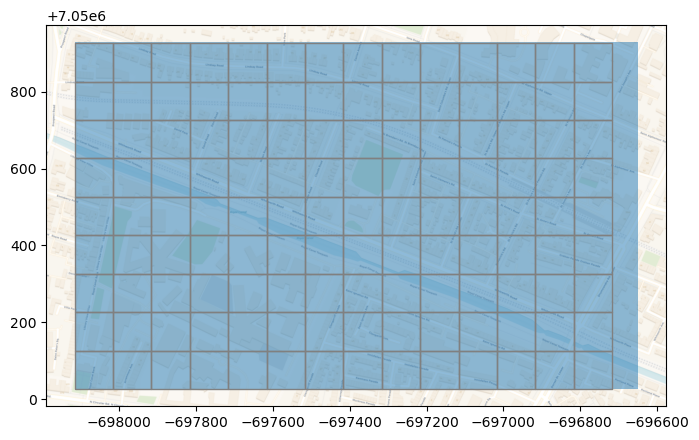

In [63]:
def create_raster_grid(gdf, size_in_km=0.1, to_file=False, plot=False):
    # Reproject to projected coordinate system
    gdf = gdf.to_crs('EPSG:3857')
    poly = gdf['geometry'][0]
    poly_centroid = poly.centroid

    print("input polygon:", poly)

    # Get the extent of the shapefile
    total_bounds = gdf.total_bounds
 
    # Get minX, minY, maxX, maxY
    minX, minY, maxX, maxY = total_bounds
 
 
    # Determine size of buffer
    poly_width = maxX-minX
    poly_height = maxY-minY

    if poly_width > poly_height:
        buffer_size = poly_width/22
    else:
        buffer_size = poly_height/22

    print("Buffer size = ", buffer_size)

    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []
 
    # Polygon Size
    square_size = size_in_km * 1000
    while y <= maxY:
        while x <= maxX:
            geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size

    fishnet = gpd.GeoSeries(geom_array).set_crs('EPSG:3857')

    poly_contains = gdf['geometry'][0].contains(fishnet)
    poly_raster = fishnet[poly_contains==True]
    
    return poly_raster

gdf = gpd.read_file('geojson_polygons/whitworth.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

gdf_raster = create_raster_grid(gdf)

fig, ax = plt.subplots(1,1,figsize=(8,6))

gdf.plot(ax=ax, alpha=0.5)
gdf_raster.plot(ax=ax, facecolor='none', edgecolor='grey')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


running tilesquares
bounds [-698116.64933369 7050026.38025795 -696649.17264212 7050928.82850912]
grid_x 20
grid_y 30
height: 902.4482511794195
grid height: 9.024482511794195


<Axes: >

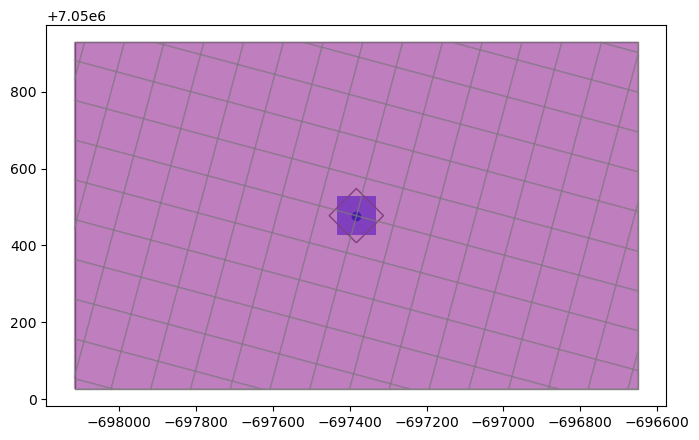

In [101]:
#square = Polygon([(-0.5, -0.5), (-0.5, 0.5), (0.5, 0.5), (0.5,-0.5)])
square = Polygon([(0.5,0.5),(0.5,1),(1,1),(1,0.5)])
pi = np.pi

def square_rotation(square, angle):
    R = np.matrix([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    origin = np.matrix([square.centroid.x, square.centroid.y]) 
    return Polygon(((np.matrix(square.exterior.coords[:-1]) - origin) * R) + origin)

def square_origin(origin, side):
    #z = np.sqrt(area)/2
    z = side/2
    ox, oy = origin.x, origin.y
    return Polygon([(ox-z,oy-z),(ox-z,oy+z), (ox+z, oy+z), (ox+z, oy-z)])

def get_bb(shape):
    bb = shape.total_bounds
    bb_poly = Polygon([(bb[0],bb[1]),(bb[0], bb[-1]),(bb[-2], bb[-1]),(bb[-2], bb[1])])
    return gpd.GeoDataFrame(pd.DataFrame([bb_poly], columns=['geometry']), geometry='geometry')

def get_bounds_points(shape):
    return gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in shape.boundary.coords], columns=['geometry']),geometry='geometry')

def tile_squares(shape, side, angle):
    print("running tilesquares")
    shape_bb = get_bb(shape)
    minx, miny, maxx, maxy = shape.total_bounds
    print("bounds", shape.total_bounds)
    ox, oy = shape.centroid.x, shape.centroid.y
    w = maxx - minx
    h = maxy - miny
    grid_y = int(2 * np.ceil(w/side))
    grid_x = int(2 * np.ceil(h/side))

    print("grid_x", grid_x)
    print("grid_y", grid_y)

    print("height:", h)
    print("grid height:", h/side)

    w_offset = abs(w - (side * grid_x))
    h_offset = abs(h - (side * grid_y))

    x = ox - (w/2 + w_offset/2) + side/2
    y = oy - (h/2 + h_offset/2) + side/2

    square_list = []
    for i in range(grid_x):
        for j in range(grid_y):
            origin = Point([x + (i*side), y + (j*side)])
            square_list.append(square_origin(origin, side))

    squares = gpd.GeoDataFrame(pd.DataFrame(square_list, columns=['geometry']), geometry='geometry')

    return gpd.GeoDataFrame(geometry=squares.rotate(angle, origin=shape.centroid.loc[0]), crs=shape.crs)

gdf = gpd.read_file('geojson_polygons/whitworth.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

square = square_origin(gdf.centroid, 100)

test_squares = tile_squares(gdf, 100, 75)

gdf_squares = gdf.overlay(test_squares, how='intersection')

fig, ax = plt.subplots(1,1,figsize=(8,6))

gdf.plot(ax=ax, facecolor='none', edgecolor='grey')
gdf.centroid.plot(ax=ax)
gpd.GeoSeries(square).plot(ax=ax, alpha=0.5, color='blue')
gpd.GeoSeries(square).rotate(45).plot(ax=ax, facecolor='none', edgecolor='grey')
#test_squares.plot(ax=ax, facecolor='orange', edgecolor='grey', alpha=0.25)
gdf_squares.plot(ax=ax, facecolor='purple', edgecolor='grey', alpha=0.5)




                                            geometry
0  POLYGON ((-696649.173 7050026.380, -696649.173...
running tilesquares
bounds [-698116.64933369 7050026.38025795 -696649.17264212 7050928.82850912]
grid_x 20
grid_y 30
height: 902.4482511794195
grid height: 9.024482511794195


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<Axes: >

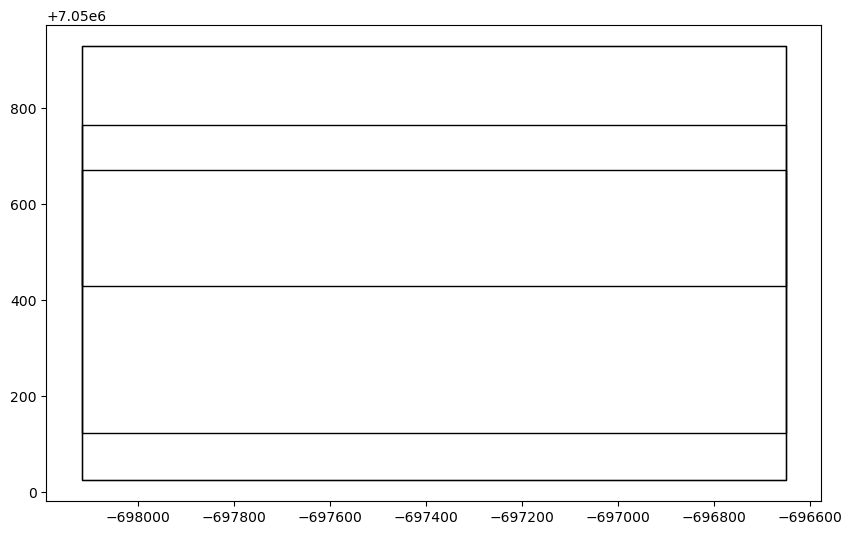

In [158]:
dcc = gpd.read_file('geojson_polygons/whitworth.geojson').to_crs(3857)
print(dcc)

rail = gpd.read_file('geojson_polygons/whitworth_rail.geojson').to_crs(3857)
dcc_squares = tile_squares(dcc, 100, 75)

rail = rail[rail['geometry'].geom_type == "LineString"]

rail_buffer = gpd.GeoDataFrame(pd.DataFrame(rail.buffer(15), columns=['geometry']), geometry='geometry')

join_test = dcc.overlay(rail_buffer, how='symmetric_difference')
rail_join = dcc.overlay(join_test, how='intersection')
join_grid = rail_join.overlay(test_squares, how='intersection')

rail_join_geoms = list(rail_join.loc[0]['geometry'].geoms)

def get_multipoly_bbs(multipoly):
    poly_list = []
    for poly in list(multipoly.geoms):
        bb = poly.bounds
        poly_list.append(Polygon([(bb[0],bb[1]),(bb[0], bb[-1]),(bb[-2], bb[-1]),(bb[-2], bb[1])]))
    return gpd.GeoDataFrame(pd.DataFrame(poly_list, columns=['geometry']), geometry='geometry')

test_bb = get_multipoly_bbs(rail_join.loc[0]['geometry'])

fig, ax = plt.subplots(1,1,figsize=(10,10))
dcc.plot(ax=ax,facecolor='none', edgecolor='grey')

#join_grid.plot(ax=ax, facecolor='blue', edgecolor='grey', alpha=0.2)
test_bb.plot(ax=ax, facecolor='none', edgecolor='black')